# Study 1
### *By what amount do incorrect transformer tap-positions impact the surrounding estimated measurement errors in the network.* 

This question will help in understanding how the parameter error influences the quality of state-estimates across the network. It will give an impression of the size of the neighbourhood that can get affected by an erroneous transformer tap-position. In simulation environment, for every state in the network, consider a set containing redundant measurements $\mathcal{M}$ ensuring full observability.

$$
\mathcal{M} = \{ V_i,P_i,Q_i | i \in \mathcal{V}\}
$$

Each measurement in $\mathcal{M}$ can be simulated by adding random Gaussian noise adopted from ABUR2004POWER with standard deviation $\sigma$ as,

* For voltage measurements: 
$$
\sigma = 0.1 \gamma \cdot FS 
$$
* For power measurements: 
$$
\sigma = \gamma \cdot FS
$$
</ol>

where $\gamma$ is the precision of the measurement and $FS$ is the full-scale value of the corresponding measurement type. Let $\mathbf{z}$ and $\hat{\mathbf{z}}$ be the true measurements (in the simulation environment) and their estimates computed from the $\mathcal{M}$. Using the notations from section on SE chapter, the residual vector will be $ \mathbf{r} = |\hat{\mathbf{z}} - \mathbf{z}|$ for this network. Now, inducing an error in the tap-position of branch $(i,j)$, the residual vector with parameter error can be defined $\mathbf{r}_{\text{pe}} = |\hat{\mathbf{z}}_{\text{pe}} - \mathbf{z}|$. Furthermore, let $\mathbf{M}^{ij}_k$ be the binary mask matrix as defined in the discussion following \eqref{eq:ch_pf_trafo_nbors}. So, $\mathbf{M}_k^{ij}\mathbf{r}$ will extract the residuals corresponding to the nodes at $k$-hop from edge $(i,j)$. 

Therefore, in this question, the magnitude of $\frac{\mathbf{M}_k^{ij}\mathbf{r_{pe}}}{\mathbf{M}_k^{ij}\mathbf{r}}$ for all $k$ is to be investigated with respect to the percentage error in the tap-position at branch $(i,j)$. This will illustrate the influence of parameter error with varying neighbourhood $k = {1,2,...,n}$ for edge $(i,j)$.

### Methodology 
[1. Load the networks.](#section-title1)

[2. Run power flow for each network and store the results to reuse them for every scenario (resolved anomaly!)](#section-title3)


[3. Custom SE Solver.](#section-title4) 


[4. Calculate RMSE (not needed)](#section-title5)


[5. Build the mask adjacency matrix as a function of $i-j$ branch and $k$-hops: $\mathbf{M}^{ij}_k$](#section-title6)


[6. Simulate parameter error for an arbitrary transformer branch.](#section-title7) 


[7. Obtain the magnitude of $\frac{\mathbf{M}_k^{ij}\mathbf{r_{pe}}}{\mathbf{M}_k^{ij}\mathbf{r}}$.](#section-title8) 


[8. Plot the results](#section-title9)


In [1]:
import pandapower as pp 
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy as np 
# from utils import custom_se
import copy 
from typing import Tuple 
import pandas as pd 
from itertools import cycle 
import os 
import joblib 
import sys 
import random 
from IPython.display import display 
from ipywidgets import widgets 

# Get the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, parent_dir)
print(parent_dir)
from utils.ppnet_utils import use_stored_pfr, custom_se, get_bus_geodata_pos, initialize_network

/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN


<a id="section-title2"></a>
### 1. Load the network.

In [2]:
net_name = 'MVO'
net = initialize_network(net_name, else_load=1.1)

Transformer Indices for MVO are available from [0,141] 

Number of Trafos = 143 
 
Network: MVO is selected 

Net MVO has 320 nodes and 318 edges. 



<a id="section-title3"></a>
### 3. Run power flow for each network and store the results to reuse them for every scenario (resolved anomaly!)

In [3]:
vm_pfr, va_pfr, p_pfr, q_pfr, p_pfr_line  = use_stored_pfr(net, parent_dir)

pfr_dict = {'vm_pfr': vm_pfr, 
            'va_pfr': va_pfr,
            'p_pfr': p_pfr,
            'q_pfr': q_pfr,
            'p_pfr_line':p_pfr_line}

Loaded pkls


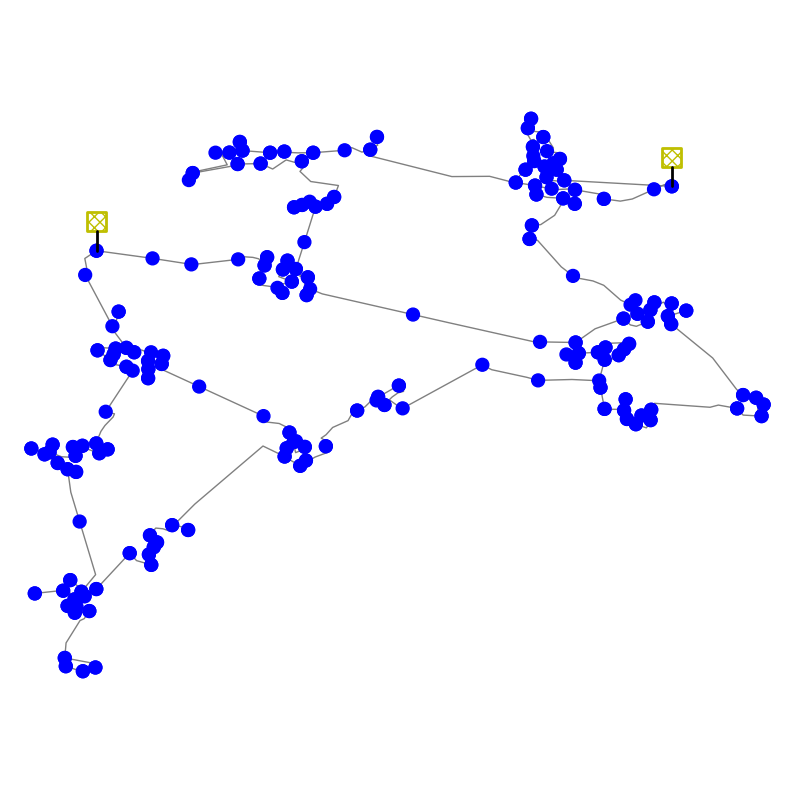

In [4]:
ax = plt.subplots(figsize=(10,10))[1]
fig1 = pp.plotting.simple_plot(net, ax = ax)

pos = get_bus_geodata_pos(net)

<a id="section-title4"></a>
### 4. Custom SE solver 

In [5]:
# use the loaded pkls to run state-estimation
net_meas = custom_se(net, pfr_dict=pfr_dict, se_iter=20,is_line_meas=False)
z_v = np.array(net_meas.measurement[net_meas.measurement.measurement_type == 'v'].value)
vm_pu_est = net_meas.res_bus_est.vm_pu

/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN/.venv/lib/python3.11/site-packages/pandapower/estimation/ppc_conversion.py:474: RuntimeWarning: invalid value encountered in cast
  )).real.astype(np.int64)
DEBUG:pandapower.estimation.state_estimation:State Estimation successful (3 iterations)


State estimation successful for MVO!
Total number of measurements = 640 and number of measurements should be at least 639


<a id="section-title5"></a>
### 5. Calculate RMSE

In [6]:
# Voltage RMSE for all three networks 
def calc_voltage_rmse(net_meas:pp.pandapowerNet, vm_pfr:np.ndarray, va_pfr:np.ndarray )->Tuple[float,float]:
    """
    Calculate the RMSE of voltage estimates 
    Input: 
        net_meas: pandapower network with measurement datastructure 
    Output: 
        rmse: float, RMSE of voltage estimates 
    """

    rmse_vm_pu = np.sqrt(np.mean((vm_pfr - net_meas.res_bus_est.vm_pu)**2))
    rmse_va_deg = np.sqrt(np.mean((va_pfr - net_meas.res_bus_est.va_degree)**2))
    
    return rmse_vm_pu, rmse_va_deg
    
# rmse 
rmse_v, rmse_a = calc_voltage_rmse(net_meas=net_meas, vm_pfr=vm_pfr, va_pfr=va_pfr)
print(f"RMSE V: {rmse_v}, RMSE A: {rmse_a}")

RMSE V: 0.00016430854425843685, RMSE A: 0.08570021954073764


<a id="section-title6"></a>
### 6. Build the mask adjacency matrix as a function of $i-j$ branch and $k$-hops: $\mathbf{M}^{ij}_k$

In [7]:
def khop_neighborhood_adjacency(net: pp.pandapowerNet, trafo_idx: int, k: int = 1) -> np.ndarray:
    """
    Returns the k-neighborhood adjacency matrix for the transformer edge in the network.
    
    :param net: pandapower network object
    :param trafo_idx: index of the transformer in the network
    :param k: number of hops to include in the adjacency matrix
    :return masked_adj: A masked adjacency matrix (NumPy array) representing k-neighborhood of the edge.
    :return masked_G: corresponding masked networkx graph
    :return original network networkx graph 
    """
    if trafo_idx in range(len(net.trafo)):
        # extract trafo buses 
        trafo_edge = (net.trafo.hv_bus[trafo_idx], net.trafo.lv_bus[trafo_idx])
    else: 
        raise KeyError(f"Trafo index exceeds {len(net.trafo)}")
    
    # create nx graph (pp.topology.create_nx sometimes creates multi-graph, so wrapping with nx.Graph)
    G_unsorted = nx.Graph(pp.topology.create_nxgraph(net, respect_switches=False)) # nodes are not sorted 

    # to keep all edge-weights = 1 (because sometimes the edge-weights are even 0. from pandapower)
    nx.set_edge_attributes(G_unsorted, values=1., name='weight')

    # sorted graph 
    sorted_nodes = sorted(G_unsorted.nodes)
    G = nx.Graph()
    G.add_nodes_from(sorted_nodes)
    G.add_edges_from(G_unsorted.edges)
    
    # k = 0 neighbours (only edge)
    if k == 0: 
        subG = nx.Graph()
        subG.add_edge(trafo_edge[0], trafo_edge[1])
    else: 
        ego_hv = nx.ego_graph(G, trafo_edge[0], radius=k)
        ego_lv = nx.ego_graph(G, trafo_edge[1], radius=k)
        subG = nx.compose(ego_hv, ego_lv)
    
    # now, create a graph adjacency matrix with edge-weights = 1 only for edges in subG else 0 
    maskedG = nx.Graph()
    maskedG.add_nodes_from(G.nodes)

    # iterate through all edges in G 
    for edge in G.edges:
        u,v = edge
        # check if edge in subG
        if not subG.has_edge(u,v):
            maskedG.add_edge(u,v,weight=0)
        else: 
            maskedG.add_edge(u,v,weight=1.)
    
    # get the masked adjacency 
    masked_adj = nx.to_numpy_array(maskedG, nodelist = G.nodes)

    return masked_adj, maskedG, G, trafo_edge

khop=1
masked_adj, maskedG, G, trafo_edge = khop_neighborhood_adjacency(net,trafo_idx=0, k = khop)
print(f"Node list of masked graph: {maskedG.nodes}")
print(f"Node list of original graph: {G.nodes}")

Node list of masked graph: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), np

MV Oberrhein may cause errors in plotting 

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal', v

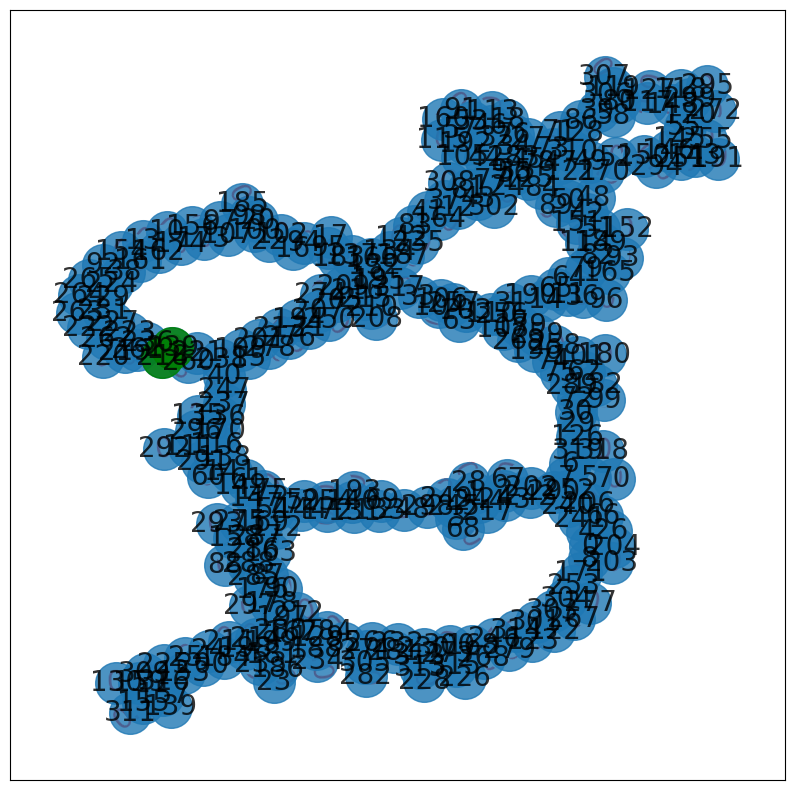

In [8]:
# Increase figure size
plt.figure(figsize=(10, 10))
# Get edge weights and draw them
edge_labels = {(u, v): f"{d['weight']:.1f}" for u, v, d in maskedG.edges(data=True)}
node_size = 900
alpha = 0.8
nx.draw_networkx(maskedG, pos, node_size=node_size,with_labels = True,font_size=20, alpha = alpha)

 # Highlight the trafo edge and nodes 
nx.draw_networkx_edges(maskedG, pos, edgelist=[trafo_edge], edge_color='red', width=5)
nx.draw_networkx_nodes(maskedG, pos, nodelist=list(trafo_edge), node_size=node_size, node_color='green', alpha = alpha)

try: 
    nx.draw_networkx_edge_labels(maskedG, pos, edge_labels=edge_labels, font_color='red', font_size = 20)   
except ValueError: 
    print("MV Oberrhein may cause errors in plotting!")

# plt.savefig('rq1_results/' + net.name + ' nxgraph k' + str(khop) + '.png', bbox_inches='tight')
plt.show()

The red line highlighted in above figure represents the defective transformer. 

<a id="section-title7"></a>
### 7. Simulate parameter error for an arbitrary transformer branch. 

In [9]:
# trafo id with simulated wrong parameter 
trafo_id_w = 4

# some networks have nan tap positions 
net.trafo['tap_pos'] = net.trafo['tap_pos'].fillna(0)

# print nominal value 
print(f"Nominal value of trafo = {net.trafo.loc[trafo_id_w,'tap_pos']}")

net_incorrect = copy.deepcopy(net)
net_incorrect.trafo.loc[trafo_id_w, 'tap_pos'] = -1

# compare power flow solution 
pp.runpp(net), pp.runpp(net_incorrect)

net.res_bus.loc[[3,7],:], net_incorrect.res_bus.loc[[3,7],:]


Nominal value of trafo = 0.0


(      vm_pu   va_degree  p_mw  q_mvar
 3  1.003078 -156.903661   0.0     0.0
 7  1.010555 -156.416885   0.0     0.0,
       vm_pu   va_degree  p_mw  q_mvar
 3  1.003084 -156.903661   0.0     0.0
 7  1.010560 -156.416864   0.0     0.0)

This shows that the voltage magnitude at the buses and angles changes for modified tap-position. Confirmed! 

<a id="section-title8"></a>
### 8. Simulate the wrong parameter state estimation, get the $\mathbf{r}_{\text{pe}}$ and obtain the magnitude of $\frac{\mathbf{M}_k^{ij}\mathbf{r_{pe}}}{\mathbf{M}_k^{ij}\mathbf{r}}$. 

Why do I use incorrect trafo SE with v_meas which is for incorrect? 

In [10]:
def simulate_pe(net: pp.pandapowerNet, # original network 
                vm_pu_est: np.ndarray, # voltage estimates from original network without any parameter error
                max_par_levels: int, # total parameter levels to simulate for 
                trafo_id_w: int, # index of wrong transformer 
                k: int)->dict: # max_neighbourhood size 
    
    # some networks have nan tap positions 
    net.trafo['tap_pos'] = net.trafo['tap_pos'].fillna(0)

    # get the nominal parameter at input trafo_id_w
    nom_par = net.trafo.at[trafo_id_w,'tap_pos']
    par_levels = nom_par + np.arange(max_par_levels)

    # initialize the output dict 
    err_mag = {level: [] for level in par_levels}

    # obtain the residuals associated without any parameter error 
    # r = z_v - vm_pu_est
    r = vm_pfr - vm_pu_est
    r_abs = np.abs(r)
    

    for pe in err_mag.keys(): 
        # net with parameter error 
        net_incorrect = copy.deepcopy(net)

        # simulate the error 
        net_incorrect.trafo.at[trafo_id_w, 'tap_pos'] = pe

        # perform SE on it 
        pp.runpp(net_incorrect)
        
        v_pfr_incorrect = np.array(net_incorrect.res_bus.vm_pu)
        va_pfr_incorrect = np.array(net_incorrect.res_bus.va_degree)
        p_pfr_incorrect = np.array(net_incorrect.res_bus.p_mw)
        q_pfr_incorrect = np.array(net_incorrect.res_bus.q_mvar)
        p_pfr_line_incorrect = np.array(net_incorrect.res_line.p_from_mw)
        
        pfr_incorrect_dict = {'vm_pfr': v_pfr_incorrect, 
            'va_pfr': va_pfr_incorrect,
            'p_pfr': p_pfr_incorrect,
            'q_pfr': q_pfr_incorrect,
            'p_pfr_line':p_pfr_line_incorrect}
        net_incorrect_meas = custom_se(net_incorrect, pfr_incorrect_dict, se_iter=20,is_line_meas=False)
        # z_pe_v = np.array(net_incorrect_meas.measurement[net_incorrect_meas.measurement.measurement_type == 'v'].value)
        
        # obtain the residuals associated with parameter error 
        # r_pe = z_v - np.array(net_incorrect_meas.res_bus_est.vm_pu)
        r_pe = vm_pfr - np.array(net_incorrect_meas.res_bus_est.vm_pu)
        r_pe_abs = np.abs(r_pe).reshape(-1,1)
        
        # use the r_pe and r to compute the error magnitude 
        for k_i in np.arange(k):
            masked_adj, _, _, _ = khop_neighborhood_adjacency(net, trafo_id_w, k_i)
            err = np.linalg.norm(masked_adj @ r_pe_abs, ord=1) / np.linalg.norm(masked_adj @ r_abs, ord=1)
            err_mag[pe].append(err)
    return err_mag, r_pe_abs, r_abs
khop = 10
err_mag, r_pe_abs, r_abs = simulate_pe(net, vm_pu_est, max_par_levels=4, trafo_id_w=4, k=khop)

/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN/.venv/lib/python3.11/site-packages/pandapower/estimation/ppc_conversion.py:474: RuntimeWarning: invalid value encountered in cast
  )).real.astype(np.int64)
DEBUG:pandapower.estimation.state_estimation:State Estimation successful (3 iterations)
/var/folders/5k/pz7fmgl977s51qnm4k4yx4400000gn/T/ipykernel_9134/2851743068.py:55: RuntimeWarning: divide by zero encountered in matmul
  err = np.linalg.norm(masked_adj @ r_pe_abs, ord=1) / np.linalg.norm(masked_adj @ r_abs, ord=1)
/var/folders/5k/pz7fmgl977s51qnm4k4yx4400000gn/T/ipykernel_9134/2851743068.py:55: RuntimeWarning: overflow encountered in matmul
  err = np.linalg.norm(masked_adj @ r_pe_abs, ord=1) / np.linalg.norm(masked_adj @ r_abs, ord=1)
/var/folders/5k/pz7fmgl977s51qnm4k4yx4400000gn/T/ipykernel_9134/2851743068.py:55: RuntimeWarning: invalid value encountered in matmul
  err = np.linalg.norm(masked_adj @ r_pe_abs, ord=1) / np.linalg.norm(masked_adj @ r_abs, ord=1)


State estimation successful for MVO!
Total number of measurements = 640 and number of measurements should be at least 639


/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN/.venv/lib/python3.11/site-packages/pandapower/estimation/ppc_conversion.py:474: RuntimeWarning: invalid value encountered in cast
  )).real.astype(np.int64)
DEBUG:pandapower.estimation.state_estimation:State Estimation successful (3 iterations)
/var/folders/5k/pz7fmgl977s51qnm4k4yx4400000gn/T/ipykernel_9134/2851743068.py:55: RuntimeWarning: divide by zero encountered in matmul
  err = np.linalg.norm(masked_adj @ r_pe_abs, ord=1) / np.linalg.norm(masked_adj @ r_abs, ord=1)
/var/folders/5k/pz7fmgl977s51qnm4k4yx4400000gn/T/ipykernel_9134/2851743068.py:55: RuntimeWarning: overflow encountered in matmul
  err = np.linalg.norm(masked_adj @ r_pe_abs, ord=1) / np.linalg.norm(masked_adj @ r_abs, ord=1)
/var/folders/5k/pz7fmgl977s51qnm4k4yx4400000gn/T/ipykernel_9134/2851743068.py:55: RuntimeWarning: invalid value encountered in matmul
  err = np.linalg.norm(masked_adj @ r_pe_abs, ord=1) / np.linalg.norm(masked_adj @ r_abs, ord=1)


State estimation successful for MVO!
Total number of measurements = 640 and number of measurements should be at least 639


/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN/.venv/lib/python3.11/site-packages/pandapower/estimation/ppc_conversion.py:474: RuntimeWarning: invalid value encountered in cast
  )).real.astype(np.int64)
DEBUG:pandapower.estimation.state_estimation:State Estimation successful (3 iterations)
/var/folders/5k/pz7fmgl977s51qnm4k4yx4400000gn/T/ipykernel_9134/2851743068.py:55: RuntimeWarning: divide by zero encountered in matmul
  err = np.linalg.norm(masked_adj @ r_pe_abs, ord=1) / np.linalg.norm(masked_adj @ r_abs, ord=1)
/var/folders/5k/pz7fmgl977s51qnm4k4yx4400000gn/T/ipykernel_9134/2851743068.py:55: RuntimeWarning: overflow encountered in matmul
  err = np.linalg.norm(masked_adj @ r_pe_abs, ord=1) / np.linalg.norm(masked_adj @ r_abs, ord=1)
/var/folders/5k/pz7fmgl977s51qnm4k4yx4400000gn/T/ipykernel_9134/2851743068.py:55: RuntimeWarning: invalid value encountered in matmul
  err = np.linalg.norm(masked_adj @ r_pe_abs, ord=1) / np.linalg.norm(masked_adj @ r_abs, ord=1)


State estimation successful for MVO!
Total number of measurements = 640 and number of measurements should be at least 639


/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN/.venv/lib/python3.11/site-packages/pandapower/estimation/ppc_conversion.py:474: RuntimeWarning: invalid value encountered in cast
  )).real.astype(np.int64)
DEBUG:pandapower.estimation.state_estimation:State Estimation successful (3 iterations)


State estimation successful for MVO!
Total number of measurements = 640 and number of measurements should be at least 639


/var/folders/5k/pz7fmgl977s51qnm4k4yx4400000gn/T/ipykernel_9134/2851743068.py:55: RuntimeWarning: divide by zero encountered in matmul
  err = np.linalg.norm(masked_adj @ r_pe_abs, ord=1) / np.linalg.norm(masked_adj @ r_abs, ord=1)
/var/folders/5k/pz7fmgl977s51qnm4k4yx4400000gn/T/ipykernel_9134/2851743068.py:55: RuntimeWarning: overflow encountered in matmul
  err = np.linalg.norm(masked_adj @ r_pe_abs, ord=1) / np.linalg.norm(masked_adj @ r_abs, ord=1)
/var/folders/5k/pz7fmgl977s51qnm4k4yx4400000gn/T/ipykernel_9134/2851743068.py:55: RuntimeWarning: invalid value encountered in matmul
  err = np.linalg.norm(masked_adj @ r_pe_abs, ord=1) / np.linalg.norm(masked_adj @ r_abs, ord=1)


In [11]:
r_pe_abs, r_abs

(array([[2.84730227e-07],
        [2.51753998e-04],
        [5.80880930e-06],
        [6.68983098e-05],
        [1.74846657e-04],
        [7.81656268e-05],
        [1.01615732e-04],
        [7.02743312e-06],
        [2.33676133e-04],
        [4.39227981e-05],
        [4.45114713e-05],
        [1.25146020e-04],
        [1.34992809e-04],
        [1.44452421e-04],
        [3.25762996e-04],
        [3.32219434e-04],
        [4.88663628e-05],
        [1.06011064e-04],
        [2.36215801e-04],
        [1.17605656e-04],
        [5.14388424e-05],
        [8.84083748e-06],
        [4.84616891e-05],
        [8.53859496e-05],
        [3.61136136e-04],
        [1.79093174e-04],
        [8.25062991e-06],
        [4.37006403e-04],
        [3.56459200e-04],
        [5.69325411e-05],
        [1.58264617e-04],
        [2.41395207e-04],
        [1.74842858e-04],
        [1.30863673e-04],
        [5.57030125e-05],
        [9.32760330e-05],
        [5.30783490e-06],
        [1.51282106e-04],
        [2.5

<a id="section-title9"></a>
### 9. Plot the results 

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/sohamprajapati/Documents/Thesis/Project Codes/TapSEGNN/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal', v

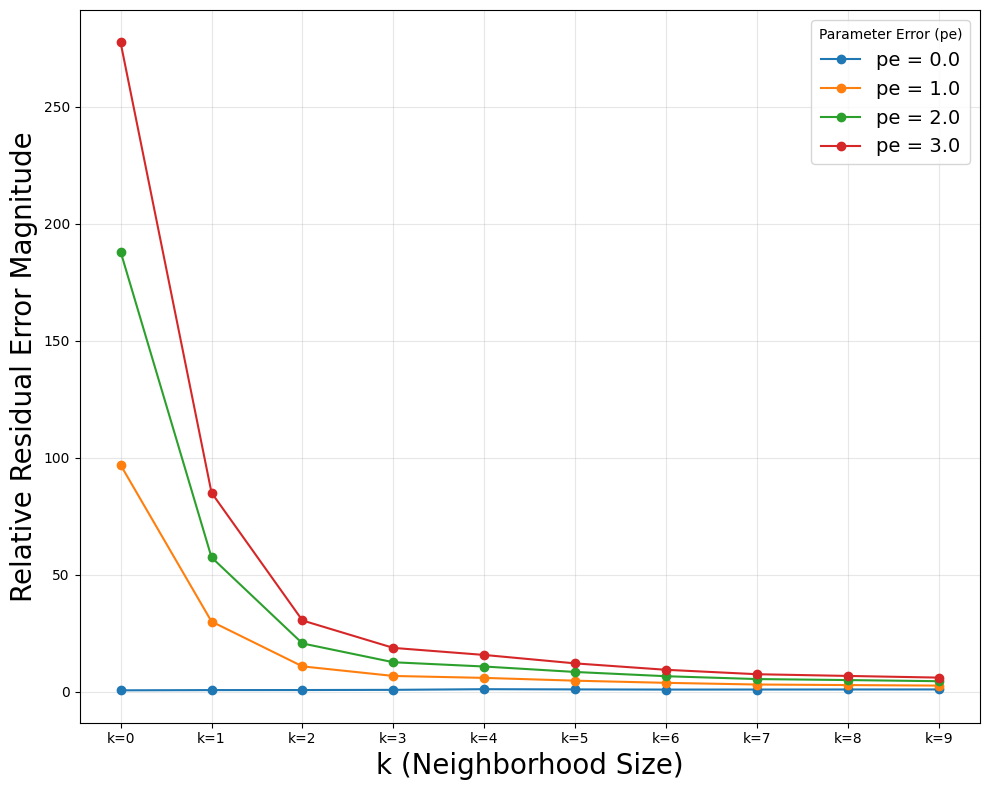

In [12]:
# Parameters
k_values = np.arange(len(next(iter(err_mag.values()))))  # Assuming all cases have the same k range
pe_values = list(err_mag.keys())
colors = cycle(plt.cm.tab10.colors)  

# Plot
plt.figure(figsize=(10, 8))

for pe, color in zip(pe_values, colors):
    plt.plot(k_values, err_mag[pe], marker='o', label=f'pe = {pe}', color=color)

# Customization
# plt.title(f'Error Magnitude vs. k for Different pe for {net.name}', fontsize=14)
plt.xlabel('k (Neighborhood Size)', fontsize=20)
plt.ylabel('Relative Residual Error Magnitude', fontsize=20)
plt.xticks(k_values, labels=[f'k={k}' for k in k_values])
plt.grid(alpha=0.3)
plt.legend(title='Parameter Error (pe)', fontsize=14)

# Show plot
plt.tight_layout()
plt.savefig(parent_dir + '/results/s1_results/' + net.name + f'_{khop}_s1.png', bbox_inches='tight')
plt.show()